## **Import Libraries**

In [15]:
import os
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import matplotlib.pyplot as plt

In [19]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(resolver)
except:
    physical_devices = tf.config.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        tf.config.set_visible_devices(physical_devices, "GPU")
        strategy = tf.distribute.MultiWorkerMirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 1


## **Load The Data**

In [ ]:
try:
    import google.colab
    if not os.path.exists("vehicles"):
        !git clone "https://github.com/denis-spe/vehicles"

    # Directory of dataset
    data_dir = "vehicles/vehicles"
except:
    # Directory of dataset
    data_dir = "vehicles"

Cloning into 'vehicles'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 92 (delta 4), reused 87 (delta 2), pack-reused 0
Receiving objects: 100% (92/92), 11.27 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
# Seed for reproducible
seed = 123

# batch size
batch_size = 1 * strategy.num_replicas_in_sync

# image shape
img_height = 300
img_width = 300

train_ds = keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.1,
            subset="training",
            seed=seed,
            image_size=(img_width, img_height),
            batch_size=batch_size,
            label_mode='categorical'
        )

val_ds = keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.1,
            subset="validation",
            seed=seed,
            image_size=(img_width, img_height),
            batch_size=batch_size,
            label_mode='categorical'
        )

Found 196 files belonging to 4 classes.
Using 177 files for training.
Found 196 files belonging to 4 classes.
Using 19 files for validation.


# **Get To Know The Data**

In [ ]:
classes = train_ds.class_names
classes

['bus', 'car', 'motorbike', 'truck']

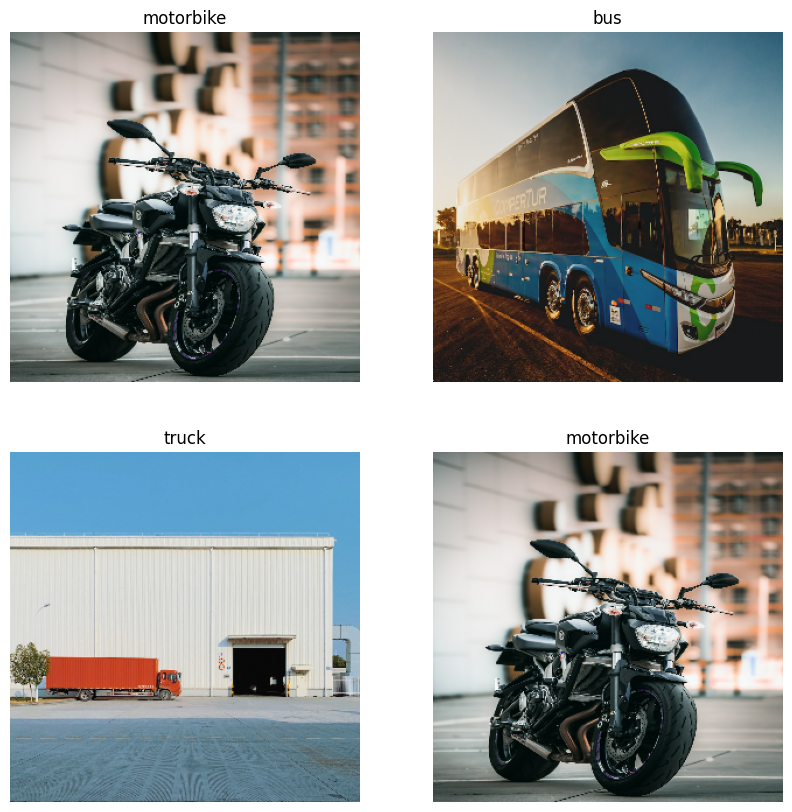

In [ ]:
# Create a figure
fig = plt.figure(figsize=(10, 10))

# Number of rows and columns
NROW = 2
NCOL = 2

for i in range(NROW + NCOL):
    img, label = next(iter(train_ds.as_numpy_iterator()))

    fig.add_subplot(NROW, NCOL, i + 1)

    plt.imshow(tf.squeeze(img) / 255)
    plt.axis("off")
    plt.title(classes[tf.argmax(label[0]).numpy()])


In [ ]:
img, label = next(iter(train_ds.as_numpy_iterator()))

In [ ]:
img_shape = img.shape[1:]
img_shape

(300, 300, 3)

## **Model Building**

In [ ]:
with strategy.scope():
    # Input layer
    input_layer = layers.Input(img_shape)
    # Flatten the data
    flatten_layer = layers.Flatten()(input_layer)
    # Hidden layer One
    hidden_layer_1 = layers.Dense(1029, activation="relu")(flatten_layer)
    # output layer
    output_layer = layers.Dense(4, activation="softmax")(hidden_layer_1)

    # Instantiate the Model object
    model = keras.Model(input_layer, output_layer)

    # Print the model summary
    model.summary()

    # Compile the model
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(),
        metrics = [
            keras.metrics.Accuracy()
        ]
    )

    # Fit the model
    model.fit(train_ds)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 270000)            0         
                                                                 
 dense_2 (Dense)             (None, 1029)              277831029 
                                                                 
 dense_3 (Dense)             (None, 4)                 4120      
                                                                 
Total params: 277835149 (1.04 GB)
Trainable params: 277835149 (1.04 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
